In [56]:


from pcpptc import PolygonInstance
from pcpptc.grid_solver.cycle_cover.fractional_grid_solver import (
    FractionalGridSolver,
)
from pcpptc.grid_solver.cycle_cover.fractional_grid_solver.integralizer import (
    IntegralizingBnBTree,
    ReducedCostBranchingStrategy,
)
from pcpptc.grid_solver.grid_instance import VertexPassage
from pcpptc.grid_solver.grid_solution import FractionalSolution
from pcpptc.grid_solver.grid_solution.coverage_analysis import (
    compute_coverage_polygon_of_grid,
)
from pcpptc.instance_converter import RotatingRegularSquare, RotatingRegularHexagonal
from pcpptc.instance_converter.dmsh import DmshGrid
import numpy as np
from pcpptc.plot import setup_plot, plot_polygon_instance
import matplotlib.pyplot as plt

In [57]:
figsize = (3.5, 3.5)

<Figure size 432x288 with 0 Axes>

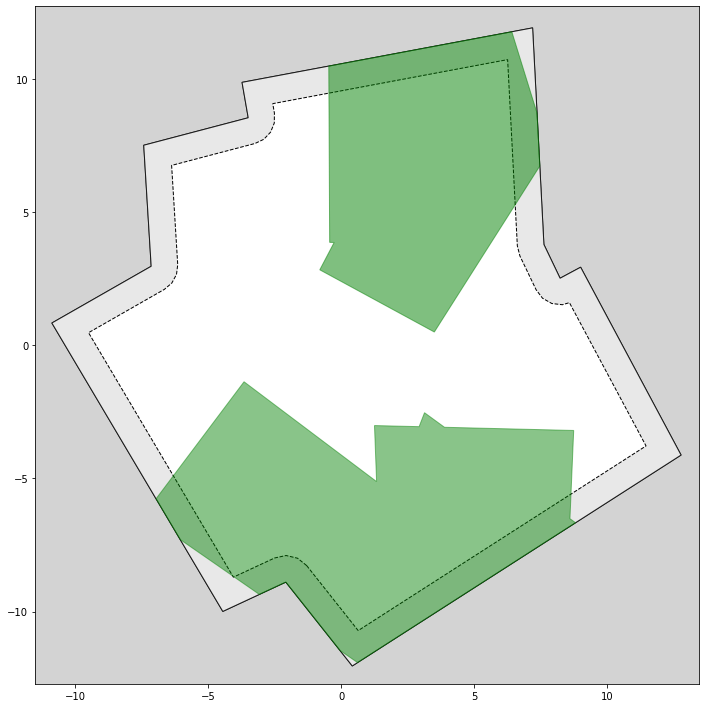

In [58]:
from pcpptc.plot.intermediate import (
    plot_graph,
    plot_points,
    plot_fractional_solution,
    plot_turn,
)

pi = PolygonInstance.from_json(file_path="./01e_instance.json")
ax = setup_plot()
plot_polygon_instance(ax, pi)
plt.show()

In [59]:
t = DmshGrid(full_coverage=False, point_based=False, buffer=0.1, simplification=0.1)
gi3 = t(pi)

<Figure size 432x288 with 0 Axes>

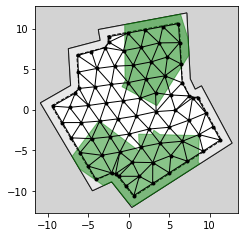

In [60]:
ax = setup_plot(figsize=figsize)
# ax = setup_plot()
plot_polygon_instance(ax, pi)
plot_graph(ax, gi3.graph, marker=".", vertex_color="black", edge_color="black")
plt.tight_layout()
plt.show()

Cycle Cover: Computing fractional solution...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 243 rows, 1255 columns and 2915 nonzeros
Model fingerprint: 0x74e707bb
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [9e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 4 columns
Presolve time: 0.01s
Presolved: 243 rows, 1251 columns, 2911 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.800000e+01   0.000000e+00      0s
     249    2.5593252e+02   0.000000e+00   0.000000e+00      0s

Solved in 249 iterations and 0.02 seconds
Optimal objective  2.559325211e+02
Cycle Cover: Creating matching problem...
Cycle Cover: Solving matching...
Solve matching on 28548 edges.


<Figure size 432x288 with 0 Axes>

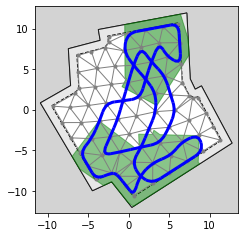

In [61]:
from pcpptc.grid_solver.cycle_cover.solver import CycleCoverSolver

cycles = CycleCoverSolver(k=3, r=2)(gi3)
ax = setup_plot(figsize=figsize)
plot_polygon_instance(ax, pi)
plot_graph(ax, gi3.graph, marker=".", vertex_color="grey", edge_color="grey")
fs = sum((c.to_fractional_solution() for c in cycles), FractionalSolution())
plot_fractional_solution(ax, fs, color="blue", linewidth=3.0, zorder=3)
plt.tight_layout()
plt.savefig("10_cc.pdf")
plt.show()

<Figure size 432x288 with 0 Axes>

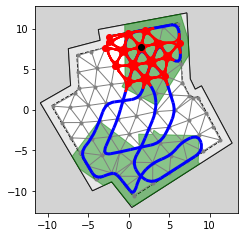

In [62]:
from pcpptc.grid_solver.cycle_cover.lns.vp_variables import (
    VertexPassageVariablesInGraph,
)
from pcpptc.grid_solver.cycle_cover.lns.area_selector import AreaSelector
import gurobipy as gp

root, area = AreaSelector(15)(gi3, fs)
model = gp.Model()
vp_vars = VertexPassageVariablesInGraph(gi3, area, fs, model)
ax = setup_plot(figsize=figsize)
plot_polygon_instance(ax, pi)
plot_graph(ax, gi3.graph, marker=".", vertex_color="grey", edge_color="grey")
fs = sum((c.to_fractional_solution() for c in cycles), FractionalSolution())
plot_fractional_solution(ax, fs, color="blue", linewidth=3.0, zorder=3)
for vp in vp_vars.keys():
    plot_turn(ax, vp.end_a, vp.v, vp.end_b, color="red", zorder=3, w=2.0)
plt.scatter([p.x for p in area], [p.y for p in area], color="red", zorder=4)
plt.scatter([root.x], [root.y], zorder=4, color="black")
plt.tight_layout()
plt.savefig("10_area.pdf")
plt.show()

Optimize CC around PointVertex[140003333342224]@(1.5330378005236063, 7.694999111338156).
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 53 rows, 220 columns and 555 nonzeros
Model fingerprint: 0x7f627c0d
Variable types: 0 continuous, 220 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Loaded user MIP start with objective 74.1063

Presolve removed 6 rows and 8 columns
Presolve time: 0.00s
Presolved: 47 rows, 212 columns, 471 nonzeros
Variable types: 0 continuous, 212 integer (28 binary)

Root relaxation: objective 7.017600e+01, 45 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      70.1760023 

<Figure size 432x288 with 0 Axes>

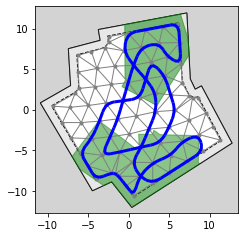

In [63]:
from pcpptc.grid_solver.cycle_cover.lns.lns import CcLns
import itertools
from pcpptc.grid_solver import PointBasedInstance
import networkx as nx


fs = sum((c.to_fractional_solution() for c in cycles), FractionalSolution())
opt = CcLns(15, 1)
fs = opt.optimize(gi3, fs)
ax = setup_plot(figsize=figsize)
plot_polygon_instance(ax, pi)
plot_graph(ax, gi3.graph, marker=".", vertex_color="grey", edge_color="grey")
plot_fractional_solution(ax, fs, color="blue", linewidth=3.0, zorder=3)
plt.tight_layout()
plt.savefig("10_1step.pdf")
plt.show()

Optimize CC around PointVertex[140003333342224]@(1.5330378005236063, 7.694999111338156).
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 53 rows, 220 columns and 555 nonzeros
Model fingerprint: 0x7f627c0d
Variable types: 0 continuous, 220 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Loaded user MIP start with objective 74.1063

Presolve removed 6 rows and 8 columns
Presolve time: 0.00s
Presolved: 47 rows, 212 columns, 471 nonzeros
Variable types: 0 continuous, 212 integer (28 binary)

Root relaxation: objective 7.017600e+01, 45 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      70.1760023 

<Figure size 432x288 with 0 Axes>

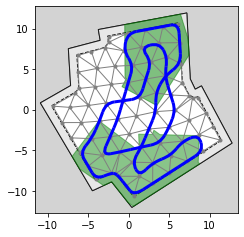

In [64]:
from pcpptc.grid_solver.cycle_cover.lns.lns import CcLns
import itertools
from pcpptc.grid_solver import PointBasedInstance
import networkx as nx


fs = sum((c.to_fractional_solution() for c in cycles), FractionalSolution())
opt = CcLns(15, 5)
fs = opt.optimize(gi3, fs)
ax = setup_plot(figsize=figsize)
plot_polygon_instance(ax, pi)
plot_graph(ax, gi3.graph, marker=".", vertex_color="grey", edge_color="grey")
plot_fractional_solution(ax, fs, color="blue", linewidth=3.0, zorder=3)
plt.tight_layout()
plt.savefig("10_5step.pdf")
plt.show()